<h1>Farmer's Market Locator</h1>

<h2>The purpose of this program is to help locate a new farmer's market. We will use the restaurants and amenities surrounding existing farmer's markets in Colorado to form a fingerprint. We will use this fingerprint to assess new locations for suitability.</h2>

<p>
Farmer’s Market Locator Workflow

1.	Import libraries
2.	Load farmer’s market data
3.	Transform farmer’s market data
4.  Write function to add and subtract distance from geo coordinates
5.	Generate null datapoints for farmer’s markets
6.	Plot lat/lon datapoints on a map
7.	Pull Foursquare restaurants & amenities for each geo coordinate
8.	Merge farmer’s market & Foursquare data
9.	Split training & test data
10.	Test k values for KNeighbors classifier
11.	Train KNeighbors classifier
12.	Create a grid of lat/lon coordinates over Denver
13. Plot test coordinates on map
14.	Pull Foursquare data for each lat/lon in the grid
15.	Run each gridpoint against the KNeighbors model
16.	Plot a map of Denver with predicted farmer's market locations from gridpoints
17. Closing thoughts


</p>

<h3>1. Import libraries</h3>

In [25]:
import types
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import json
import ibm_boto3
import csv
import itertools

from pandas.io.json import json_normalize
from botocore.client import Config
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score


import pylab as pl
import scipy.optimize as opt
%matplotlib inline 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

!conda install -c conda-forge folium=0.5.0 --yes #comment once installed
import folium # map rendering library
from folium import plugins
pd.options.mode.chained_assignment = None  # default='warn'


Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    ------------------------------------------------------------
                       

<h3>2. Load farmer's market data</h3>

In [26]:
# The code was removed by Watson Studio for sharing.

FMID                                        MarketName  \
0  1018261   Caledonia Farmers Market Association - Danville   
1  1018318                 Stearns Homestead Farmers' Market   
2  1009364                 106 S. Main Street Farmers Market   
3  1010691               10th Steet Community Farmers Market   
4  1002454                              112st Madison Avenue   

                                             Website  \
0  https://sites.google.com/site/caledoniafarmers...   
1                    http://www.StearnsHomestead.com   
2             http://thetownofsixmile.wordpress.com/   
3                                                NaN   
4                                                NaN   

                                            Facebook Twitter Youtube  \
0  https://www.facebook.com/Danville.VT.Farmers.M...     NaN     NaN   
1                      StearnsHomesteadFarmersMarket     NaN     NaN   
2                                                NaN     NaN     NaN   
3                                                NaN     NaN     NaN   
4                                                NaN     NaN     NaN   

                                          OtherMedia                  street  \
0                                                NaN                     NaN   
1                                                NaN         6975 Ridge Road   
2                                                NaN      106 S. Main Street   
3  http://agrimissouri.com/mo-grown/grodetail.php...  10th Street and Poplar   
4                                                NaN    112th Madison Avenue   

       city     County  ... Coffee Beans Fruits Grains Juices Mushrooms  \
0  Danville  Caledonia  ...      Y     Y      Y      N      N         Y   
1    Parma    Cuyahoga  ...      N     N      Y      N      N         N   
2  Six Mile    Pickens  ...    NaN   NaN    NaN    NaN    NaN       NaN   
3    Lamar      Barton  ...      N     N      Y      N      N         N   
4  New York   New York  ...      N     N      N      N      N         N   

  PetFood Tofu WildHarvested       updateTime  
0       Y    N             N  6/20/2017 22:43  
1       N    N             N  6/21/2017 17:15  
2     NaN  NaN           NaN             2013  
3       N    N             N  10/28/2014 9:49  
4       N    N             N   3/1/2012 10:38  

[5 rows x 59 columns]

<h3>3. Transform farmer's market data</h3>

In [27]:
print("Available farmer's market features: \n")
print(df_data_1.columns.values)
print(" \n Available farmer's market entries:", df_data_1.shape[0])

Available farmer's market features: 

['FMID' 'MarketName' 'Website' 'Facebook' 'Twitter' 'Youtube' 'OtherMedia'
 'street' 'city' 'County' 'State' 'zip' 'Season1Date' 'Season1Time'
 'Season2Date' 'Season2Time' 'Season3Date' 'Season3Time' 'Season4Date'
 'Season4Time' 'x' 'y' 'Location' 'Credit' 'WIC' 'WICcash' 'SFMNP' 'SNAP'
 'Organic' 'Bakedgoods' 'Cheese' 'Crafts' 'Flowers' 'Eggs' 'Seafood'
 'Herbs' 'Vegetables' 'Honey' 'Jams' 'Maple' 'Meat' 'Nursery' 'Nuts'
 'Plants' 'Poultry' 'Prepared' 'Soap' 'Trees' 'Wine' 'Coffee' 'Beans'
 'Fruits' 'Grains' 'Juices' 'Mushrooms' 'PetFood' 'Tofu' 'WildHarvested'
 'updateTime']
 
 Available farmer's market entries: 8804


In [28]:
trainingStates = ['Colorado', 'California']
stateFilter = df_data_1[df_data_1.State.isin(trainingStates)]
print("Filtered farmer's market entries:", stateFilter.shape[0])

Filtered farmer's market entries: 921


In [29]:
farmersMarkets = stateFilter[['FMID','MarketName','x','y']]
farmersMarkets.columns = ['id', 'name', 'lon', 'lat']
farmersMarkets['farmersMarket'] = 1.0
farmersMarkets.sort_values("name", inplace = True)
farmersMarkets.dropna(inplace=True)
farmersMarkets.drop_duplicates(subset ="name", keep = False, inplace = True)
farmersMarkets.head()

id                              name        lon        lat  \
37   1006234         4th Street Farmers Market -105.07300  40.395401   
90   1005272   Adelanto Stadium Farmers Market -117.40500  34.559299   
109  1009019           Alameda Farmers' Market -122.27676  37.774246   
114  1004070            Alamosa Farmers Market -105.86523  37.468361   
137  1008835  Alisal Certified Farmers' Market -121.63418  36.673321   

     farmersMarket  
37             1.0  
90             1.0  
109            1.0  
114            1.0  
137            1.0

In [30]:
print("Filtered & cleaned farmer's market entries:", farmersMarkets.shape[0])

Filtered & cleaned farmer's market entries: 901


<h3>4. Write function to add and subtract distance from geo coordinates</h3>
<p>This function probably won't be used, but I've kept it for reference. Instead I will use the math to calculate the latitude offsets which will then be used to generate the negative datapoints. 

In [31]:
def addDistance(distance, lat, lon, angle):
        distanceNorth = math.sin(math.radians(angle)) * distance
        distanceEast = math.cos(math.radians(angle)) * distance
        
        earthRadius = 3959
        
        newLat = lat + (distanceNorth / earthRadius) * 180 / math.pi
        newLon = lon + (distanceEast / (earthRadius * math.cos(math.radians(newLat * 180 / math.pi )))) * 180 / math.pi
        
        return (newLat, newLon)

In [32]:
North =  90
South = 270
East = 180
West = 0

distOffset = addDistance(15, 39.7255006,-105.0235998, South)
latOffsetPerMile = (39.7255006 - distOffset[0])/15
lonOffsetPerMile = (-105.0235998 - distOffset[1])
print("Southern transform:\n\n", "The lat offset is:", latOffsetPerMile, ", The lon offset is:", lonOffsetPerMile)

Southern transform:

 The lat offset is: 0.014472285807800725 , The lon offset is: 0.0


In [33]:
threeMiles = (latOffsetPerMile * 3)
sixMiles = (latOffsetPerMile * 6)
twentyMiles = (latOffsetPerMile * 20)
sixtyMiles = (latOffsetPerMile * 60)

print("Three mile lat offset: ", threeMiles, "\n")
print("Six mile lat offset: ", sixMiles, "\n")
print("20 mile lat offset: ", twentyMiles, "\n")
print("60 mile lat offset: ", sixtyMiles)

Three mile lat offset:  0.04341685742340218 

Six mile lat offset:  0.08683371484680436 

20 mile lat offset:  0.2894457161560145 

60 mile lat offset:  0.8683371484680436


<h3>5. Generate null datapoints for farmer’s markets</h3>

In [34]:
threeMilesAway = farmersMarkets.copy()
sixMilesAway = farmersMarkets.copy()
twentyMilesAway = farmersMarkets.copy()
sixtyMilesAway = farmersMarkets.copy()

threeMilesAway['lat'] = threeMilesAway['lat'] - threeMiles
threeMilesAway['id'] = threeMilesAway['id'] * 2
farmersMarketNegative = threeMilesAway

sixMilesAway['lat'] = sixMilesAway['lat'] - sixMiles
sixMilesAway['id'] = sixMilesAway['id'] * 3
farmersMarketNegative = farmersMarketNegative.append(sixMilesAway, ignore_index = True)

twentyMilesAway['lat'] = twentyMilesAway['lat'] - twentyMiles
twentyMilesAway['id'] = twentyMilesAway['id'] * 4
farmersMarketNegative = farmersMarketNegative.append(twentyMilesAway, ignore_index = True)

sixtyMilesAway['lat'] = sixtyMilesAway['lat'] - sixtyMiles
sixtyMilesAway['id'] = sixtyMilesAway['id'] * 5
farmersMarketNegative = farmersMarketNegative.append(sixtyMilesAway, ignore_index = True)

farmersMarketNegative['farmersMarket'] = 0.0

print("We have generated: ", farmersMarketNegative.shape[0], "coordinates where there are no farmer's markets.")

We have generated:  3604 coordinates where there are no farmer's markets.


In [35]:
farmersMarketCombined = farmersMarkets.append(farmersMarketNegative, ignore_index = True)
del farmersMarketCombined['name']
farmersMarketCombined = farmersMarketCombined.rename(columns={"id":"uniqueId"})

print("Our combined dataset has ", farmersMarketCombined.shape[0], "datapoints")

Our combined dataset has  4505 datapoints


<h3>6. Plot lat/lon datapoints on a map </h3>

In [36]:
mapMarkets = folium.Map(location=[38.8056732, -114.1795341], zoom_start=6)

# instantiate a feature group for the rows in the dataframe
markets = folium.map.FeatureGroup()
negatives = folium.map.FeatureGroup()

marketsPlotted=0
negativesPlotted=0

# loop through rows and add each to the markets feature group
for lat, lon, in zip(farmersMarkets.lat, farmersMarkets.lon):
    marketsPlotted = marketsPlotted + 1
    markets.add_child(
        folium.features.CircleMarker(
            [lat, lon],
            radius=2, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )
    
# loop through rows and add each to the negatives feature group
for lat, lon, in zip(farmersMarketNegative.lat, farmersMarketNegative.lon):
    negativesPlotted = negativesPlotted + 1
    negatives.add_child(
        folium.features.CircleMarker(
            [lat, lon],
            radius=2, # define how big you want the circle markers to be
            color='red',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )


# add incidents to map
mapMarkets.add_child(markets)
mapMarkets.add_child(negatives)
mapMarkets

In [37]:
print(marketsPlotted, "farmer's markets were plotted in yellow")
print(negativesPlotted, "negatives were plotted in red")

901 farmer's markets were plotted in yellow
3604 negatives were plotted in red


<h3> Pull Foursquare restaurants & amenities for each geo coordinate </h3>

In [38]:
CLIENT_ID = '# your Foursquare ID' # your Foursquare ID
CLIENT_SECRET = '# your Foursquare Secret' # your Foursquare Secret
VERSION = '20200625' # Foursquare API version
LIMIT = 100

print('Your credentials: \n')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials: 

CLIENT_ID: DUO51K4ES33Q5R35LKCRAIXLWT522H2F51UDN4KEKQJ40Q4B
CLIENT_SECRET:RA1QLEBRAXALQ2SZA3TCCYBTC3K4OBGRLW4QGHCLBUHPEDMX


In [39]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    counter=0
    total = len(names)
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        counter = counter + 1
        print(counter, "of", total)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])

            nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
            nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
        except:
            continue
            
    return(nearby_venues)

In [19]:
farmersMarketVenues = getNearbyVenues(names=farmersMarketCombined['uniqueId'], latitudes=farmersMarketCombined['lat'], longitudes=farmersMarketCombined['lon'])

1 of  4505
2 of  4505
3 of  4505
4 of  4505
5 of  4505
6 of  4505
7 of  4505
8 of  4505
9 of  4505
10 of  4505
11 of  4505
12 of  4505
13 of  4505
14 of  4505
15 of  4505
16 of  4505
17 of  4505
18 of  4505
19 of  4505
20 of  4505
21 of  4505
22 of  4505
23 of  4505
24 of  4505
25 of  4505
26 of  4505
27 of  4505
28 of  4505
29 of  4505
30 of  4505
31 of  4505
32 of  4505
33 of  4505
34 of  4505
35 of  4505
36 of  4505
37 of  4505
38 of  4505
39 of  4505
40 of  4505
41 of  4505
42 of  4505
43 of  4505
44 of  4505
45 of  4505
46 of  4505
47 of  4505
48 of  4505
49 of  4505
50 of  4505
51 of  4505
52 of  4505
53 of  4505
54 of  4505
55 of  4505
56 of  4505
57 of  4505
58 of  4505
59 of  4505
60 of  4505
61 of  4505
62 of  4505
63 of  4505
64 of  4505
65 of  4505
66 of  4505
67 of  4505
68 of  4505
69 of  4505
70 of  4505
71 of  4505
72 of  4505
73 of  4505
74 of  4505
75 of  4505
76 of  4505
77 of  4505
78 of  4505
79 of  4505
80 of  4505
81 of  4505
82 of  4505
83 of  4505
84 of  4505
8

In [20]:
farmersMarketVenues.to_csv('farmersMarketVenues.csv', index = False, header=True)
print("File saved!")

File saved!


In [40]:
farmersMarketVenues = pd.read_csv("farmersMarketVenues.csv")
print("File loaded!")

FileNotFoundError: [Errno 2] File b'farmersMarketVenues.csv' does not exist: b'farmersMarketVenues.csv'

In [22]:
print("There are ", farmersMarketVenues.shape[0], "venues in our dataset")
farmersMarketVenues.head()

There are  32531 venues in our dataset


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0       1006234              40.395401                -105.073   
1       1006234              40.395401                -105.073   
2       1006234              40.395401                -105.073   
3       1006234              40.395401                -105.073   
4       1006234              40.395401                -105.073   

                    Venue  Venue Latitude  Venue Longitude  \
0         The Coffee Tree       40.395321      -105.074217   
1        Verboten Brewing       40.396638      -105.075114   
2                Door 222       40.395280      -105.073922   
3             Henry's Pub       40.395312      -105.073650   
4  Laureate Publick House       40.396900      -105.073027   

            Venue Category  
0              Coffee Shop  
1                  Brewery  
2  New American Restaurant  
3                      Pub  
4                      Pub

In [23]:
print('There are {} unique categories.'.format(len(farmersMarketVenues['Venue Category'].unique())))

There are 555 unique categories.


In [24]:
# one hot encoding
farmers_onehot = pd.get_dummies(farmersMarketVenues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
farmers_onehot['Neighborhood'] = farmersMarketVenues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [farmers_onehot.columns[-1]] + list(farmers_onehot.columns[:-1])
farmers_onehot = farmers_onehot[fixed_columns]

farmers_grouped = farmers_onehot.groupby('Neighborhood').mean().reset_index()

farmers_grouped.head()

Neighborhood  Zoo Exhibit  ATM  Acai House  Accessories Store  \
0       1000007          0.0  0.0         0.0           0.027027   
1       1000015          0.0  0.0         0.0           0.000000   
2       1000024          0.0  0.0         0.0           0.000000   
3       1000038          0.0  0.0         0.0           0.000000   
4       1000052          0.0  0.0         0.0           0.000000   

   Adult Boutique  Advertising Agency  Afghan Restaurant  African Restaurant  \
0             0.0                 0.0                0.0                 0.0   
1             0.0                 0.0                0.0                 0.0   
2             0.0                 0.0                0.0                 0.0   
3             0.0                 0.0                0.0                 0.0   
4             0.0                 0.0                0.0                 0.0   

   Airport  ...  Weight Loss Center  Whisky Bar  Wine Bar  Wine Shop  Winery  \
0      0.0  ...                 0.0         0.0       0.0   0.000000     0.0   
1      0.0  ...                 0.0         0.0       0.0   0.000000     0.0   
2      0.0  ...                 0.0         0.0       0.0   0.000000     0.0   
3      0.0  ...                 0.0         0.0       0.0   0.000000     0.0   
4      0.0  ...                 0.0         0.0       0.0   0.012048     0.0   

   Wings Joint  Women's Store  Yoga Studio  Yoshoku Restaurant  Zoo  
0          0.0            0.0          0.0                 0.0  0.0  
1          0.0            0.0          0.0                 0.0  0.0  
2          0.0            0.0          0.0                 0.0  0.0  
3          0.0            0.0          0.0                 0.0  0.0  
4          0.0            0.0          0.0                 0.0  0.0  

[5 rows x 555 columns]

<h3> 8. Merge farmer’s market & Foursquare data </h3>

In [25]:
farmers_grouped.rename(columns={"Neighborhood":"uniqueId"}, inplace = True)
farmersMarketShort = farmersMarketCombined.copy()
del farmersMarketShort['lon']
del farmersMarketShort['lat']
farmersFinal = pd.merge(farmers_grouped, farmersMarketShort, on ="uniqueId", how ='right')
farmersFinal = farmersFinal.fillna(0.0)
farmersFinal.head()

uniqueId  Zoo Exhibit  ATM  Acai House  Accessories Store  Adult Boutique  \
0   1000007          0.0  0.0         0.0           0.027027             0.0   
1   1000015          0.0  0.0         0.0           0.000000             0.0   
2   1000024          0.0  0.0         0.0           0.000000             0.0   
3   1000038          0.0  0.0         0.0           0.000000             0.0   
4   1000052          0.0  0.0         0.0           0.000000             0.0   

   Advertising Agency  Afghan Restaurant  African Restaurant  Airport  ...  \
0                 0.0                0.0                 0.0      0.0  ...   
1                 0.0                0.0                 0.0      0.0  ...   
2                 0.0                0.0                 0.0      0.0  ...   
3                 0.0                0.0                 0.0      0.0  ...   
4                 0.0                0.0                 0.0      0.0  ...   

   Whisky Bar  Wine Bar  Wine Shop  Winery  Wings Joint  Women's Store  \
0         0.0       0.0   0.000000     0.0          0.0            0.0   
1         0.0       0.0   0.000000     0.0          0.0            0.0   
2         0.0       0.0   0.000000     0.0          0.0            0.0   
3         0.0       0.0   0.000000     0.0          0.0            0.0   
4         0.0       0.0   0.012048     0.0          0.0            0.0   

   Yoga Studio  Yoshoku Restaurant  Zoo  farmersMarket  
0          0.0                 0.0  0.0            1.0  
1          0.0                 0.0  0.0            1.0  
2          0.0                 0.0  0.0            1.0  
3          0.0                 0.0  0.0            1.0  
4          0.0                 0.0  0.0            1.0  

[5 rows x 556 columns]

In [30]:
farmersFinalCorr = farmersFinal.corr(method='pearson')
farmersFinalCorr.sort_values(by=['farmersMarket'], ascending=False,  inplace=True)

farmersFinalCorrPosIndex = farmersFinalCorr.farmersMarket >= 0.2
farmersPosCorr = farmersFinalCorr.farmersMarket[farmersFinalCorrPosIndex]
del farmersPosCorr['farmersMarket']
farmersPosCorrList = farmersPosCorr.index.values.tolist()
print("There are ", farmersPosCorr.shape[0], "features with a positive correlation greater than 0.2")

farmersFinalCorrNegIndex = farmersFinalCorr.farmersMarket <= -0.1
farmersNegCorr = farmersFinalCorr.farmersMarket[farmersFinalCorrNegIndex]
del farmersNegCorr['uniqueId']
print("There are ", farmersNegCorr.shape[0],"features with a negative correlation less than 0.2")

There are  13 features with a positive correlation greater than 0.2
There are  0 features with a negative correlation less than 0.2


In [31]:
print("Positively correlated features: \n", farmersFinalCorr.farmersMarket.head(20))
print("\n\n Negatively correlated features: \n", farmersFinalCorr.farmersMarket.tail(20))

Positively correlated features: 
 farmersMarket              1.000000
Coffee Shop                0.341027
Mexican Restaurant         0.277326
Pizza Place                0.274646
New American Restaurant    0.267435
Sandwich Place             0.252067
Farmers Market             0.228694
French Restaurant          0.228382
American Restaurant        0.225018
Bank                       0.221761
Bakery                     0.220333
Café                       0.212782
Italian Restaurant         0.203440
Ice Cream Shop             0.201679
Bar                        0.192968
Chinese Restaurant         0.184168
Juice Bar                  0.183660
Grocery Store              0.182588
Sushi Restaurant           0.181690
Thai Restaurant            0.173383
Name: farmersMarket, dtype: float64


 Negatively correlated features: 
 Auto Garage                  -0.013530
Outdoors & Recreation        -0.013762
Airport Service              -0.013949
Airport Terminal             -0.014089
Zoo Exhibit      

<h3>9. Split training & test data</h3>

In [32]:
train, test = train_test_split(farmersFinal, test_size=0.2, random_state=4)
print("The training set has ", train.shape[0], "datapoints" )
print("The testing set has ", test.shape[0], "datapoints" )

The training set has  3604 datapoints
The testing set has  901 datapoints


<h3>10.	Test k values for KNeighbors classifier</h3>


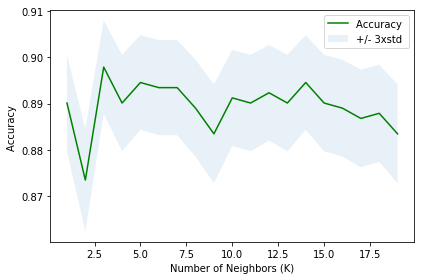

In [33]:
Ks = 20
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(train[farmersPosCorrList],train['farmersMarket'])
    yhat=neigh.predict(test[farmersPosCorrList])
    mean_acc[n-1] = metrics.accuracy_score(test['farmersMarket'], yhat)

    std_acc[n-1]=np.std(yhat==test['farmersMarket'])/np.sqrt(yhat.shape[0])

mean_acc

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

<h3>11.	Train KNeighbors classifier</h3>

In [63]:
k = 5
neigh = KNeighborsClassifier(n_neighbors = k).fit(train[farmersPosCorrList],train['farmersMarket'])
yhat = neigh.predict(test[farmersPosCorrList])

print("Train set accuracy: ", metrics.accuracy_score(train['farmersMarket'], neigh.predict(train[farmersPosCorrList])))
print("Test set accuracy: ", metrics.accuracy_score(test['farmersMarket'], yhat))

KNNJaccard = jaccard_similarity_score(test['farmersMarket'], yhat)
KNNF1 = f1_score(test['farmersMarket'], yhat, average='weighted')
KNNLogLoss = log_loss(test['farmersMarket'], yhat)

Train set accuracy:  0.908157602663707
Test set accuracy:  0.8945615982241953


In [64]:
print("\n\nK-Nearest Neighbor")
print(KNNJaccard)
print(KNNF1)
print(KNNLogLoss)



K-Nearest Neighbor
0.8945615982241953
0.8942088987144214
3.641754205325532


<h3>11.2 Decision Tree </h3

In [58]:
decisionTree = DecisionTreeClassifier(criterion="entropy", max_depth = 7)
decisionTree.fit(train[farmersPosCorrList],train['farmersMarket'])
predDecisionTree = decisionTree.predict(test[farmersPosCorrList])

decisionTreeJaccard = jaccard_similarity_score(test['farmersMarket'], predDecisionTree)
decisionTreeF1 = f1_score(test['farmersMarket'], predDecisionTree, average='weighted')
decisionTreeLogLoss = log_loss(test['farmersMarket'], predDecisionTree)

print("The decision trees's accuracy is: ", metrics.accuracy_score(test['farmersMarket'], predDecisionTree))

The decision trees's accuracy is:  0.8890122086570478


In [60]:
print("Decision Tree")
print(decisionTreeJaccard)
print(decisionTreeF1)
print(decisionTreeLogLoss)

Decision Tree
0.8890122086570478
0.8857759186862115
3.8334162310692745


<h3> 11.3 Support Vector Machine </h3>

In [42]:
clf = svm.SVC(kernel='rbf', gamma='scale')
clf.fit(train[farmersPosCorrList], train['farmersMarket'])
yhat = clf.predict(test[farmersPosCorrList])

z = f1_score(test['farmersMarket'], yhat, average='weighted') + jaccard_similarity_score(test['farmersMarket'], yhat)
print("F1 Score + Jaccard for RBF: ", z)

F1 Score + Jaccard for RBF:  1.78526499119974


In [43]:
clf = svm.SVC(kernel='poly', gamma='scale')
clf.fit(train[farmersPosCorrList], train['farmersMarket'])
yhat = clf.predict(test[farmersPosCorrList])

z = f1_score(test['farmersMarket'], yhat, average='weighted') + jaccard_similarity_score(test['farmersMarket'], yhat)
print("F1 Score + Jaccard for Poly: ", z)

F1 Score + Jaccard for Poly:  1.763539623901962


In [44]:
clf = svm.SVC(kernel='sigmoid', gamma='scale')
clf.fit(train[farmersPosCorrList], train['farmersMarket'])
yhat = clf.predict(test[farmersPosCorrList])

z = f1_score(test['farmersMarket'], yhat, average='weighted') + jaccard_similarity_score(test['farmersMarket'], yhat)
print("F1 Score + Jaccard for Sigmoid: ", z)

F1 Score + Jaccard for Sigmoid:  1.6497486821872274


In [46]:
clf = svm.SVC(kernel='linear', )
clf.fit(train[farmersPosCorrList], train['farmersMarket'])
yhat = clf.predict(test[farmersPosCorrList])

z = f1_score(test['farmersMarket'], yhat, average='weighted') + jaccard_similarity_score(test['farmersMarket'], yhat)
print("F1 Score + Jaccard for Linear: ", z)

SVMJaccard = jaccard_similarity_score(test['farmersMarket'], yhat)
SVMF1 = f1_score(test['farmersMarket'], yhat, average='weighted')
SVMLogLoss = log_loss(test['farmersMarket'], yhat)

F1 Score + Jaccard for Linear:  1.7345057027196962


In [48]:
print("Support Vector Machine")
print(SVMJaccard)
print(SVMF1)
print(SVMLogLoss)

Support Vector Machine
0.8701442841287459
0.8643614185909502
4.4850939197549256


<h3>11.4 Logistic Regression</h3>

In [55]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(train[farmersPosCorrList],train['farmersMarket'])
yhat = LR.predict(test[farmersPosCorrList])
jaccard_similarity_score(test['farmersMarket'], yhat)

LogRegJaccard = jaccard_similarity_score(test['farmersMarket'], yhat)
LogRegF1 = f1_score(test['farmersMarket'], yhat, average='weighted', labels=np.unique(yhat))
LogRegLogLoss = log_loss(test['farmersMarket'], yhat)

In [56]:
print("Logistic Regression")
print(LogRegJaccard)
print(LogRegF1)
print(LogRegLogLoss)

Logistic Regression
0.8079911209766926
0.8937998772252918
6.631751738423472


<h3>11.5 Model Selection</h3>

In [61]:
data = {'Algorithm':  ["KNN", "Decision Tree", "SVM", "LogisticRegression"],'Jaccard': [KNNJaccard, decisionTreeJaccard, SVMJaccard, LogRegJaccard],'F1-score': [KNNF1, decisionTreeF1, SVMF1, LogRegF1],'LogLoss': [KNNLogLoss, decisionTreeLogLoss, SVMLogLoss, LogRegLogLoss]}
table=pd.DataFrame(data, columns =["Algorithm","Jaccard", "F1-score", "LogLoss"])
table = table.set_index('Algorithm')
table

Jaccard  F1-score   LogLoss
Algorithm                                       
KNN                 0.890122  0.890946  3.795096
Decision Tree       0.889012  0.885776  3.833416
SVM                 0.870144  0.864361  4.485094
LogisticRegression  0.807991  0.893800  6.631752

<h3>12.	Create a grid of lat/lon coordinates</h3>

In [67]:
originLat = 38.9629633
originLon = -104.8307238

endLat = originLat - 0.21708428711701
endLon = originLon + 0.21708428711701

y = np.linspace(originLat, endLat, num = 45)
x = np.linspace(originLon, endLon, num = 45)
xx,yy=np.meshgrid(y,x)
coords=np.array((xx.ravel(), yy.ravel())).T

testPoints = pd.DataFrame(coords)
testPoints.columns = ['lat', 'lon']

<h3>13. Plot test coordinates on map</h3>

In [68]:
mapTestGrid = folium.Map(location=[38.8553977, -104.7187621], zoom_start=12)

# instantiate a feature group for the rows in the dataframe
testPointsPlot = folium.map.FeatureGroup()

testPointsPlotted=0

# loop through rows and add each to the markets feature group
for lat, lon, in zip(testPoints.lat, testPoints.lon):
    testPointsPlotted = testPointsPlotted + 1
    testPointsPlot.add_child(
        folium.features.CircleMarker(
            [lat, lon],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add incidents to map
mapTestGrid.add_child(testPointsPlot)
mapTestGrid

<h3>14. Pull Foursquare data for each lat/lon in the grid</h3>

In [69]:
testPoints.insert(0, 'New_ID', range(0, 0 + len(testPoints)))
print(testPoints.shape[0], "test coordinates have been created")

2025 test coordinates have been created


In [70]:
testPointsVenues = getNearbyVenues(names=testPoints['New_ID'], latitudes=testPoints['lat'], longitudes=testPoints['lon'])

1 of  2025
2 of  2025
3 of  2025
4 of  2025
5 of  2025
6 of  2025
7 of  2025
8 of  2025
9 of  2025
10 of  2025
11 of  2025
12 of  2025
13 of  2025
14 of  2025
15 of  2025
16 of  2025
17 of  2025
18 of  2025
19 of  2025
20 of  2025
21 of  2025
22 of  2025
23 of  2025
24 of  2025
25 of  2025
26 of  2025
27 of  2025
28 of  2025
29 of  2025
30 of  2025
31 of  2025
32 of  2025
33 of  2025
34 of  2025
35 of  2025
36 of  2025
37 of  2025
38 of  2025
39 of  2025
40 of  2025
41 of  2025
42 of  2025
43 of  2025
44 of  2025
45 of  2025
46 of  2025
47 of  2025
48 of  2025
49 of  2025
50 of  2025
51 of  2025
52 of  2025
53 of  2025
54 of  2025
55 of  2025
56 of  2025
57 of  2025
58 of  2025
59 of  2025
60 of  2025
61 of  2025
62 of  2025
63 of  2025
64 of  2025
65 of  2025
66 of  2025
67 of  2025
68 of  2025
69 of  2025
70 of  2025
71 of  2025
72 of  2025
73 of  2025
74 of  2025
75 of  2025
76 of  2025
77 of  2025
78 of  2025
79 of  2025
80 of  2025
81 of  2025
82 of  2025
83 of  2025
84 of  2025
8

In [71]:
testPointsVenues.to_csv('testPointsVenues.csv', index = False, header=True)
print("File saved!")

File saved!


In [72]:
testPointsVenues = pd.read_csv("testPointsVenues.csv")
print("File loaded!")

File loaded!


In [73]:
# one hot encoding
testPoints_onehot = pd.get_dummies(testPointsVenues[['Venue Category']], prefix="", prefix_sep="")
testPoints_onehot.head()

# add neighborhood column back to dataframe
testPoints_onehot['New_ID'] = testPoints['New_ID'] 

# move neighborhood column to the first column
fixed_columns = [testPoints_onehot.columns[-1]] + list(testPoints_onehot.columns[:-1])
testPoints_onehot = testPoints_onehot[fixed_columns]

testPoints_grouped = testPoints_onehot.groupby('New_ID').mean().reset_index()
testPoints_grouped.head()

New_ID  ATM  Accessories Store  Adult Boutique  Airport  Airport Lounge  \
0     0.0    0                  0               0        0               0   
1     1.0    0                  0               0        0               0   
2     2.0    0                  0               0        0               0   
3     3.0    0                  0               0        0               0   
4     4.0    0                  0               0        0               0   

   Airport Service  Airport Terminal  American Restaurant  Antique Shop  ...  \
0                0                 0                    0             0  ...   
1                0                 0                    0             0  ...   
2                0                 0                    0             0  ...   
3                0                 0                    0             0  ...   
4                0                 0                    0             0  ...   

   Vietnamese Restaurant  Warehouse Store  Waste Facility  Water Park  \
0                      0                0               0           0   
1                      0                0               0           0   
2                      0                0               0           0   
3                      0                0               0           0   
4                      0                0               0           0   

   Weight Loss Center  Wine Bar  Wine Shop  Wings Joint  Women's Store  \
0                   0         0          0            0              0   
1                   0         0          0            0              0   
2                   0         0          0            0              0   
3                   0         0          0            0              0   
4                   0         0          0            0              0   

   Yoga Studio  
0            0  
1            0  
2            0  
3            0  
4            0  

[5 rows x 303 columns]

<h3>15. Run each gridpoint against the KNeighbors model </h3>

In [74]:
trainingColumns = train.copy()
testPointsColumns = testPoints_grouped.copy()
col_list = list(set().union(trainingColumns.columns, testPointsColumns.columns))
col_list.sort()

testPoints_grouped = testPoints_grouped.reindex(columns=col_list, fill_value=0)

trainColumns = train.columns
testPointsColumns = testPoints_grouped.columns

columnDiff = list(set(testPoints_grouped.columns.values) - set(train.columns.values))
testPoints_grouped = testPoints_grouped.drop(columnDiff, axis = 1)

print(train.shape)
print(testPoints_grouped.shape)

(3604, 556)
(2025, 556)


In [75]:
testPointResults = neigh.predict(testPoints_grouped[farmersPosCorrList])
flattenedResults = pd.DataFrame(data=testPointResults.flatten())
flattenedResults.rename(columns={0:"farmersMarket"}, inplace = True)

<h3>16. Plot a map with predicted farmer's market locations from gridpoints</h3>

In [78]:
testPoints = testPoints.join(flattenedResults, how='outer')

positives = testPoints[(testPoints.farmersMarket == 1.0)]
print("There are", positives.shape[0], "matches")

negatives = testPoints[(testPoints.farmersMarket == 0.0)]
print("There are", negatives.shape[0], "unmatched points")

There are 57 matches
There are 1968 unmatched points


In [83]:
mapPrediction = folium.Map(location=[38.8553977, -104.7187621], zoom_start=12)

# instantiate a feature group for the rows in the dataframe
predictedLocations = folium.map.FeatureGroup()
noPred = folium.map.FeatureGroup()
markets = folium.map.FeatureGroup()

PointsPlotted=0

# loop through rows and add each to the markets feature group
for lat, lon, in zip(positives.lat, positives.lon):
    PointsPlotted = PointsPlotted + 1
    predictedLocations.add_child(
        folium.features.CircleMarker(
            [lat, lon],
            radius=5, # define how big you want the circle markers to be
            color='red',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )
        
for lat, lon, in zip(negatives.lat, negatives.lon):
    PointsPlotted = PointsPlotted + 1
    noPred.add_child(
        folium.features.CircleMarker(
            [lat, lon],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )
    
for lat, lon, in zip(farmersMarkets.lat, farmersMarkets.lon):
    PointsPlotted = PointsPlotted + 1
    markets.add_child(
        folium.features.CircleMarker(
            [lat, lon],
            radius=5, # define how big you want the circle markers to be
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add incidents to map
mapPrediction.add_child(predictedLocations)
#mapPrediction.add_child(noPred)
mapPrediction.add_child(markets)
mapPrediction

<h3>17. Closing thoughts</h3> 

<p>There were 57 farmer’s market matches out of 2025 analyzed coordinates.This match rate of 3% makes the algorithm selective enough to be useful for locating new markets.To simplify our selection process we can cluster using two adjacent matches. Requiring two adjacent matches simplifies site selection and guarantees a higher level of local supporting infrastructure than an isolated match would.